In [1]:
from model.neural_model import NeuralModel
import matplotlib.pyplot as plt
import numpy as np
from model import RLConn

In [2]:
Gg = np.array([[0, 8, 5],
                 [8, 0, 2],
                 [5, 2, 0]])
Gs = np.array([[0, 2, 8],
                 [7, 0, 3],
                 [7, 7, 0]])
is_inhibitory = np.array([1, 0 ,0])
I_ext = 100000 * np.array([0, 0.03 ,0])
model = NeuralModel(
            N = 3,
            Gg = Gg,
            Gs = Gs,
            is_inhibitory = is_inhibitory,
            I_ext = I_ext)
(v_mat, s_mat, v_normalized_mat) = model.run(1000)
true_v = v_normalized_mat[250:,:].flatten()

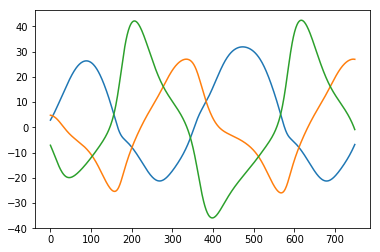

In [3]:
plt.plot(v_normalized_mat[250:])

In [4]:
def get_random_connectome(N):
    l = int(N*(N-1)/2)
    Gg = np.zeros((N,N))
    Gg[np.logical_not(np.tri(N,dtype=bool))] = np.random.randint(0,10,l)
    Gg += Gg.T
    Gs = np.zeros((N,N))
    Gs[np.tri(N,dtype=bool,k=-1)] = np.random.rand(l)
    Gs[np.logical_not(np.tri(N,dtype=bool))] = np.random.randint(0,10,l)
    return Gg, Gs

In [5]:
def get_reward(Gg, Gs):
    '''get v_normalized with 1000 time_step
    '''
    model = NeuralModel(
        N = Gg.shape[0],
        Gg = Gg,
        Gs = Gs,
        is_inhibitory = is_inhibitory,
        I_ext = I_ext)
    (v_mat, s_mat, v_normalized_mat) = model.run(1000)
    actual = v_normalized_mat[250:].flatten()
    error = np.linalg.norm(actual-true_v)
    np.random.seed() #reset seed
    return -error

In [6]:
def get_observe(Gg, Gs):
    N = Gg.shape[0]
    return np.concatenate((Gg[np.triu_indices(N,k=1)],Gs[np.triu_indices(N,k=1)],Gs[np.tril_indices(N,k=-1)]))

In [7]:
def move(Gg, Gs, action, location, dx = 0.1):
    N = Gg.shape[0]
    size = int(N*(N-1)/2)
    change = dx*(action == 0) + (-dx)*(action == 2)
    if location < size:
        coordinate = np.array(np.triu_indices(N,k=1)).T[location]
        Gg[coordinate[0], coordinate[1]] += change
        Gg[coordinate[1], coordinate[0]] += change
    elif location < 2*size:
        coordinate = np.array(np.triu_indices(N,k=1)).T[location - size]
        Gs[coordinate[0], coordinate[1]] += change
    else: 
        coordinate = np.array(np.tril_indices(N,k=-1)).T[location - 2*size]
        Gs[coordinate[0], coordinate[1]] += change
    return Gg, Gs

In [13]:
def get_rand_action(N):
    size = int(N*(N-1)/2)
    return np.random.randint(2), np.random.randint(size)

In [9]:
def update_x(x, Gg, Gs, reward):
    obs = get_observe(Gg, Gs)
    x = np.concatenate((x[len(obs)+1:], obs))
    x = np.append(x,reward)
    return x

In [10]:
"""
This part of code is the reinforcement learning brain, which is a brain of the agent.
All decisions are made in here.

Policy Gradient, Reinforcement Learning.

View more on my tutorial page: https://morvanzhou.github.io/tutorials/

Using:
Tensorflow: 1.0
gym: 0.8.0
"""

import numpy as np
import tensorflow as tf

# reproducible
#np.random.seed(1)
#tf.set_random_seed(1)


class PolicyGradient:
    def __init__(
            self,
            n_actions,
            n_features,
            learning_rate=0.01,
            reward_decay=0.95,
            output_graph=False,
    ):
        self.n_actions = n_actions
        self.n_locations = int(3*n_actions*(n_actions-1)/2)
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay

        self.ep_obs, self.ep_as, self.ep_aps, self.ep_rs = [], [], [], []

        self._build_net()

        self.sess = tf.Session()

        if output_graph:
            # $ tensorboard --logdir=logs
            # http://0.0.0.0:6006/
            # tf.train.SummaryWriter soon be deprecated, use following
            tf.summary.FileWriter("logs/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer())

    def _build_net(self):
        with tf.name_scope('inputs'):
            self.tf_obs = tf.placeholder(tf.float32, [None, self.n_features], name="observations")
            self.tf_acts = tf.placeholder(tf.int32, [None, ], name="actions_num")
            self.tf_act_locs = tf.placeholder(tf.int32, [None, ], name="actions_location")
            self.tf_vt = tf.placeholder(tf.float32, [None, ], name="actions_value")
        # fc1
        layer = tf.layers.dense(
            inputs=self.tf_obs,
            units=10,
            activation=tf.nn.tanh,  # tanh activation
            kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.3),
            bias_initializer=tf.constant_initializer(0.1),
            name='fc1'
        )
        # fc2
        all_act = tf.layers.dense(
            inputs=layer,
            units=self.n_actions,
            activation=None,
            kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.3),
            bias_initializer=tf.constant_initializer(0.1),
            name='fc_act'
        )
        
        all_loc = tf.layers.dense(
            inputs=layer,
            units=self.n_locations,
            activation=None,
            kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.3),
            bias_initializer=tf.constant_initializer(0.1),
            name='fc_fea'
        )

        self.all_act_prob = tf.nn.softmax(all_act, name='act_prob')  # use softmax to convert to probability
        self.all_loc_prob = tf.nn.softmax(all_loc, name='loc_prob')

        with tf.name_scope('loss'):
            # to maximize total reward (log_p * R) is to minimize -(log_p * R), and the tf only have minimize(loss)
            nll_act = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=all_act, labels=self.tf_acts)   # this is negative log of chosen action
            nll_act_loc = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=all_loc, labels=self.tf_act_locs)
            # or in this way:
            # neg_log_prob = tf.reduce_sum(-tf.log(self.all_act_prob)*tf.one_hot(self.tf_acts, self.n_actions), axis=1)
            loss = tf.reduce_mean((nll_act + nll_act_loc) * self.tf_vt)  # reward guided loss

        with tf.name_scope('train'):
            self.train_op = tf.train.AdamOptimizer(self.lr).minimize(loss)

    def choose_action(self, observation):
        act_prob_weights = self.sess.run(self.all_act_prob, feed_dict={self.tf_obs: observation[np.newaxis, :]})
        loc_prob_weights = self.sess.run(self.all_loc_prob, feed_dict={self.tf_obs: observation[np.newaxis, :]})
        #print(loc_prob_weights)
        action = np.random.choice(range(act_prob_weights.shape[1]), p=act_prob_weights.ravel())  # select action w.r.t the actions prob
        location = np.random.choice(range(loc_prob_weights.shape[1]), p=loc_prob_weights.ravel())
        test = [np.random.choice(range(loc_prob_weights.shape[1]), p=loc_prob_weights.ravel()) for i in range(10)]
        #print(test)
        return action, location

    def store_transition(self, s, a, ap, r):
        self.ep_obs.append(s)
        self.ep_as.append(a)
        self.ep_aps.append(ap)
        self.ep_rs.append(r)

    def learn(self):
        # discount and normalize episode reward
        discounted_ep_rs_norm = self._discount_and_norm_rewards()

        # train on episode
        self.sess.run(self.train_op, feed_dict={
             self.tf_obs: np.vstack(self.ep_obs),  # shape=[None, n_obs]
             self.tf_acts: np.array(self.ep_as),  # shape=[None, ]
             self.tf_act_locs: np.array(self.ep_aps),
             self.tf_vt: discounted_ep_rs_norm,  # shape=[None, ]
        })

        self.ep_obs, self.ep_as, self.ep_aps, self.ep_rs = [], [], [], []    # empty episode data
        return discounted_ep_rs_norm

    def _discount_and_norm_rewards(self):
        # discount episode rewards
        discounted_ep_rs = np.zeros_like(self.ep_rs)
        running_add = 0
        for t in reversed(range(0, len(self.ep_rs))):
            running_add = running_add * self.gamma + self.ep_rs[t]
            discounted_ep_rs[t] = running_add

        # normalize episode rewards
        discounted_ep_rs -= np.mean(discounted_ep_rs)
        discounted_ep_rs /= np.std(discounted_ep_rs)
        return discounted_ep_rs

In [11]:
# initialize
N = 3
size = int(3*N*(N-1)/2)
RL = PolicyGradient(
    n_actions=3,
    n_features=(size+1)*10)

W0409 10:59:24.633151 4553264576 deprecation.py:323] From <ipython-input-10-df78bf84aab7>:64: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


In [14]:
for i_episode in range(3000):
    #initialize x
    x = np.array([])
    Gg, Gs = get_random_connectome(N)
    reward = get_reward(Gg, Gs)
    x = np.concatenate((x, get_observe(Gg, Gs)))
    x = np.append(x,reward)
    for i in range(9):
        action, location = get_rand_action(N)
        Gg, Gs = move(Gg, Gs, action, location, dx=0.1)
        reward = get_reward(Gg, Gs)
        x = np.concatenate((x, get_observe(Gg, Gs)))
        x = np.append(x,reward)    
    
    #choose action using nn
    for step in range(300):
        action, location = RL.choose_action(x)
        Gg, Gs = move(Gg, Gs, action, location, dx=0.1)
        reward = get_reward(Gg, Gs)
        RL.store_transition(x, action, location, reward)
        x = update_x(x, Gg, Gs, reward)
    ep_rs_sum = sum(RL.ep_rs)
    if 'running_reward' not in globals():
        running_reward = ep_rs_sum
    else:
        running_reward = running_reward * 0.99 + ep_rs_sum * 0.01
    print("episode:", i_episode, "  reward:", int(running_reward))
    print("Gg:", Gg.flatten(), "  Gs:", Gs.flatten())
    vt = RL.learn()
    # print(vt)

episode: 0   reward: -107529
Gg: [0.  4.  7.6 4.  0.  6.4 7.6 6.4 0. ]   Gs: [0.         7.8        8.         3.45671298 0.         7.9
 0.77265629 1.77766512 0.        ]
episode: 1   reward: -110218
Gg: [0.  8.1 1.1 8.1 0.  7.2 1.1 7.2 0. ]   Gs: [0.         0.1        7.         3.14865933 0.         8.1
 0.95241167 2.30812426 0.        ]
episode: 2   reward: -115038
Gg: [0.  7.7 0.8 7.7 0.  0.2 0.8 0.2 0. ]   Gs: [0.         5.2        1.1        1.43453095 0.         2.
 1.02753338 0.29242544 0.        ]


KeyboardInterrupt: 

In [ ]:
RL.ep_rs

In [ ]:
act_prob_weights= RL.sess.run(RL.all_act_prob, feed_dict={RL.tf_obs: x[np.newaxis, :]})
np.random.choice(range(act_prob_weights.shape[1]), p=act_prob_weights.ravel()) 

In [ ]:
loc_prob_weights = RL.sess.run(RL.all_loc_prob, feed_dict={RL.tf_obs: x[np.newaxis, :]})
np.random.choice(range(loc_prob_weights.shape[1]), p=loc_prob_weights.ravel()) 

In [ ]:
RL.choose_action(observation)

In [ ]:
RL.choose_action(np.array([0.53758721, 0.891773  , 0.96366276, 0.56804456, 0.92559664,
        0.07103606, 0.38344152, 0.79172504, 0.52889492]))

In [ ]:
act_prob_weights = np.array([[0.40533334, 0.4321859,  0.16248076]])
np.random.choice(range(act_prob_weights.shape[1]), p=act_prob_weights.ravel())

In [2]:
from model import RL_brain

W0304 16:42:19.946266 4542545344 deprecation_wrapper.py:119] From /Users/Frank/github/Reinforcement-learning-with-tensorflow-master/contents/model/RL_brain.py:19: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.



In [3]:
# initialize
RL = RL_brain.PolicyGradient(
    n_actions=3,
    n_features=10*2
)

f = lambda x: x**2

for i_episode in range(3000):
    #initialize x
    x = np.array([])
    obs = np.random.randint(-10,10)
    reward = -f(obs)
    x = np.append(x,obs)
    x = np.append(x,reward)
    for i in range(9):
        action = np.random.randint(-1,2)
        obs += action*0.1
        reward = -f(obs)
        x = np.append(x,obs)
        x = np.append(x,reward)   
    #choose action using nn
    for step in range(100):
        action = RL.choose_action(x)
        obs += (action-1)*0.1
        reward = -f(obs)
        RL.store_transition(x, action, reward)
        x = np.append(x[2:],obs)
        x = np.append(x,reward) 
    ep_rs_sum = sum(RL.ep_rs)
    if 'running_reward' not in globals():
        running_reward = ep_rs_sum
    else:
        running_reward = running_reward * 0.99 + ep_rs_sum * 0.01
    print("episode:", i_episode, "  reward:", int(running_reward), "  x:", obs)
    vt = RL.learn()
    # print(vt)

W0304 16:42:20.406718 4542545344 deprecation_wrapper.py:119] From /Users/Frank/github/Reinforcement-learning-with-tensorflow-master/contents/model/RL_brain.py:52: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0304 16:42:20.418740 4542545344 deprecation.py:323] From /Users/Frank/github/Reinforcement-learning-with-tensorflow-master/contents/model/RL_brain.py:62: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0304 16:42:20.727828 4542545344 deprecation_wrapper.py:119] From /Users/Frank/github/Reinforcement-learning-with-tensorflow-master/contents/model/RL_brain.py:84: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W0304 16:42:20.838768 4542545344 deprecation_wrapper.py:119] From /Users/Frank/github/Reinforcement-learning-with-tensorflow-master/contents/model/RL_brain.py:40: The name tf.S

episode: 0   reward: -1576   x: -2.500000000000002
episode: 1   reward: -1565   x: -0.5999999999999984
episode: 2   reward: -1664   x: 12.699999999999983
episode: 3   reward: -1732   x: 10.99999999999999
episode: 4   reward: -1736   x: -2.900000000000006
episode: 5   reward: -1740   x: 5.599999999999995
episode: 6   reward: -1742   x: 5.999999999999994
episode: 7   reward: -1770   x: -5.000000000000007
episode: 8   reward: -1833   x: 10.499999999999991
episode: 9   reward: -1848   x: -3.40000000000001
episode: 10   reward: -1891   x: -5.900000000000015
episode: 11   reward: -1878   x: -0.400000000000001
episode: 12   reward: -1900   x: 8.199999999999985
episode: 13   reward: -1881   x: 0.6
episode: 14   reward: -1866   x: 0.20000000000000154
episode: 15   reward: -1966   x: 13.099999999999985
episode: 16   reward: -1949   x: 3.1000000000000014
episode: 17   reward: -1987   x: -4.900000000000015
episode: 18   reward: -1968   x: 0.10000000000000153
episode: 19   reward: -2017   x: -5.800

episode: 162   reward: -2888   x: 9.71445146547012e-16
episode: 163   reward: -2902   x: 3.6000000000000174
episode: 164   reward: -2925   x: -9.199999999999985
episode: 165   reward: -3017   x: -12.999999999999986
episode: 166   reward: -3124   x: -13.699999999999983
episode: 167   reward: -3140   x: -8.499999999999988
episode: 168   reward: -3111   x: -1.5265566588595902e-15
episode: 169   reward: -3099   x: -5.699999999999995
episode: 170   reward: -3174   x: -12.099999999999989
episode: 171   reward: -3149   x: -0.09999999999999903
episode: 172   reward: -3165   x: -8.599999999999987
episode: 173   reward: -3152   x: -6.399999999999993
episode: 174   reward: -3171   x: 4.300000000000017
episode: 175   reward: -3243   x: -11.799999999999986
episode: 176   reward: -3211   x: -0.10000000000000064
episode: 177   reward: -3316   x: -12.89999999999999
episode: 178   reward: -3330   x: -8.599999999999987
episode: 179   reward: -3297   x: -0.4
episode: 180   reward: -3412   x: -13.89999999

episode: 318   reward: -3520   x: 5.600000000000001
episode: 319   reward: -3566   x: -9.1
episode: 320   reward: -3530   x: 2.7755575615628914e-17
episode: 321   reward: -3496   x: -1.3877787807814457e-16
episode: 322   reward: -3544   x: -9.1
episode: 323   reward: -3531   x: 4.0000000000000036
episode: 324   reward: -3495   x: 1.3877787807814457e-16
episode: 325   reward: -3461   x: 0.30000000000000016
episode: 326   reward: -3426   x: 0.10000000000000003
episode: 327   reward: -3410   x: 3.7000000000000033
episode: 328   reward: -3429   x: 6.800000000000004
episode: 329   reward: -3400   x: -2.4000000000000004
episode: 330   reward: -3423   x: 7.0000000000000036
episode: 331   reward: -3399   x: 2.399999999999998
episode: 332   reward: -3366   x: 0.09999999999999937
episode: 333   reward: -3413   x: -9.0
episode: 334   reward: -3407   x: 4.700000000000005
episode: 335   reward: -3379   x: 1.799999999999999
episode: 336   reward: -3345   x: 0.10000000000000003
episode: 337   reward:

episode: 474   reward: -3843   x: -0.20000000000000287
episode: 475   reward: -3832   x: -0.19999999999998477
episode: 476   reward: -3798   x: -0.09999999999999898
episode: 477   reward: -3849   x: -11.59999999999998
episode: 478   reward: -3852   x: -8.599999999999984
episode: 479   reward: -3823   x: -0.09999999999999187
episode: 480   reward: -3811   x: -8.299999999999986
episode: 481   reward: -3774   x: 0.1999999999999976
episode: 482   reward: -3737   x: -0.09999999999999987
episode: 483   reward: -3702   x: -0.10000000000000286
episode: 484   reward: -3669   x: 0.10000000000000103
episode: 485   reward: -3678   x: -8.699999999999983
episode: 486   reward: -3641   x: -0.10000000000000064
episode: 487   reward: -3753   x: -14.699999999999983
episode: 488   reward: -3751   x: -8.299999999999985
episode: 489   reward: -3772   x: -9.499999999999988
episode: 490   reward: -3778   x: -8.799999999999983
episode: 491   reward: -3803   x: -9.699999999999983
episode: 492   reward: -3783  

episode: 629   reward: -2495   x: 1.1685097334179773e-14
episode: 630   reward: -2472   x: -0.10000000000000292
episode: 631   reward: -2449   x: -1.5265566588595902e-15
episode: 632   reward: -2500   x: -9.199999999999996
episode: 633   reward: -2475   x: 1.3877787807814457e-16
episode: 634   reward: -2468   x: 0.10000000000001169
episode: 635   reward: -2443   x: 8.326672684688674e-17
episode: 636   reward: -2543   x: -12.299999999999992
episode: 637   reward: -2617   x: -11.699999999999987
episode: 638   reward: -2598   x: 4.579669976578771e-15
episode: 639   reward: -2594   x: -0.09999999999998477
episode: 640   reward: -2635   x: -9.59999999999999
episode: 641   reward: -2633   x: 1.5237811012980274e-14
episode: 642   reward: -2630   x: -0.09999999999998482
episode: 643   reward: -2623   x: -5.399999999999995
episode: 644   reward: -2611   x: 0.10000000000001169
episode: 645   reward: -2710   x: -12.099999999999993
episode: 646   reward: -2743   x: -9.199999999999989
episode: 647 

episode: 781   reward: -1692   x: -6.38378239159465e-16
episode: 782   reward: -1676   x: 1.3877787807814457e-16
episode: 783   reward: -1667   x: 0.10000000000000459
episode: 784   reward: -1677   x: -0.09999999999998477
episode: 785   reward: -1660   x: 0.09999999999999987
episode: 786   reward: -1648   x: 2.858824288409778e-15
episode: 787   reward: -1632   x: -0.19999999999999937
episode: 788   reward: -1616   x: 0.09999999999999937
episode: 789   reward: -1611   x: -0.10000000000000459
episode: 790   reward: -1595   x: -0.10000000000000064
episode: 791   reward: -1592   x: 8.132383655379272e-15
episode: 792   reward: -1576   x: -0.20000000000000065
episode: 793   reward: -1568   x: -4.579669976578771e-15
episode: 794   reward: -1556   x: -0.10000000000000103
episode: 795   reward: -1553   x: -0.19999999999999188
episode: 796   reward: -1578   x: -1.7000000000000193
episode: 797   reward: -1581   x: 0.09999999999998832
episode: 798   reward: -1567   x: -2.858824288409778e-15
episod

episode: 933   reward: -1305   x: 2.200000000000016
episode: 934   reward: -1300   x: -4.579669976578771e-15
episode: 935   reward: -1313   x: 1.500000000000012
episode: 936   reward: -1317   x: 0.2000000000000117
episode: 937   reward: -1309   x: 0.10000000000000103
episode: 938   reward: -1297   x: -1.5265566588595902e-15
episode: 939   reward: -1284   x: 6.38378239159465e-16
episode: 940   reward: -1271   x: -6.38378239159465e-16
episode: 941   reward: -1260   x: 0.19999999999999848
episode: 942   reward: -1281   x: 2.4000000000000163
episode: 943   reward: -1302   x: -2.000000000000016
episode: 944   reward: -1309   x: 2.200000000000009
episode: 945   reward: -1297   x: 0.10000000000000153
episode: 946   reward: -1289   x: 0.299999999999999
episode: 947   reward: -1277   x: -0.09999999999999848
episode: 948   reward: -1292   x: 1.8000000000000123
episode: 949   reward: -1300   x: 1.4000000000000083
episode: 950   reward: -1306   x: 0.5000000000000081
episode: 951   reward: -1319   

episode: 1088   reward: -4272   x: -0.10000000000000103
episode: 1089   reward: -4275   x: 10.899999999999979
episode: 1090   reward: -4232   x: 0.1
episode: 1091   reward: -4213   x: -0.10000000000001524
episode: 1092   reward: -4171   x: -0.10000000000000003
episode: 1093   reward: -4259   x: 15.899999999999965
episode: 1094   reward: -4272   x: 11.799999999999974
episode: 1095   reward: -4303   x: 12.89999999999997
episode: 1096   reward: -4271   x: -8.132383655379272e-15
episode: 1097   reward: -4326   x: 14.099999999999964
episode: 1098   reward: -4300   x: -1.1685097334179773e-14
episode: 1099   reward: -4294   x: -0.5000000000000188
episode: 1100   reward: -4287   x: 10.199999999999982
episode: 1101   reward: -4244   x: -0.10000000000000014
episode: 1102   reward: -4281   x: 13.399999999999967
episode: 1103   reward: -4243   x: -1.0269562977782698e-15
episode: 1104   reward: -4201   x: 0.10000000000000064
episode: 1105   reward: -4175   x: -0.10000000000001169
episode: 1106   re

episode: 1239   reward: -4198   x: 10.49999999999998
episode: 1240   reward: -4320   x: 17.399999999999988
episode: 1241   reward: -4281   x: 0.09999999999999898
episode: 1242   reward: -4348   x: 14.999999999999964
episode: 1243   reward: -4322   x: 0.09999999999998832
episode: 1244   reward: -4302   x: -1.5237811012980274e-14
episode: 1245   reward: -4259   x: 0.09999999999999987
episode: 1246   reward: -4406   x: 18.300000000000008
episode: 1247   reward: -4509   x: 16.599999999999977
episode: 1248   reward: -4498   x: -0.7000000000000187
episode: 1249   reward: -4556   x: 14.599999999999966
episode: 1250   reward: -4512   x: 0.10000000000000153
episode: 1251   reward: -4478   x: 0.09999999999999187
episode: 1252   reward: -4433   x: 6.38378239159465e-16
episode: 1253   reward: -4408   x: -0.10000000000001169
episode: 1254   reward: -4372   x: 0.19999999999999543
episode: 1255   reward: -4529   x: 18.80000000000001
episode: 1256   reward: -4495   x: -8.132383655379272e-15
episode: 1

episode: 1390   reward: -5245   x: 0.19999999999999188
episode: 1391   reward: -5351   x: 17.199999999999985
episode: 1392   reward: -5330   x: -1.8790524691780774e-14
episode: 1393   reward: -5308   x: 0.19999999999998122
episode: 1394   reward: -5308   x: 11.599999999999975
episode: 1395   reward: -5293   x: -0.5000000000000188
episode: 1396   reward: -5240   x: 0.10000000000000003
episode: 1397   reward: -5205   x: 0.19999999999998833
episode: 1398   reward: -5169   x: -1.1685097334179773e-14
episode: 1399   reward: -5125   x: -4.524158825347513e-15
episode: 1400   reward: -5074   x: 1.582067810090848e-15
episode: 1401   reward: -5075   x: 11.399999999999975
episode: 1402   reward: -5128   x: 14.699999999999966
episode: 1403   reward: -5155   x: 13.299999999999967
episode: 1404   reward: -5140   x: 10.099999999999982
episode: 1405   reward: -5124   x: 9.999999999999982
episode: 1406   reward: -5097   x: -1.5237811012980274e-14
episode: 1407   reward: -5098   x: 11.499999999999975
ep

episode: 1544   reward: -5511   x: 16.89999999999998
episode: 1545   reward: -5511   x: 11.699999999999974
episode: 1546   reward: -5559   x: 14.499999999999966
episode: 1547   reward: -5504   x: 0.10000000000000242
episode: 1548   reward: -5498   x: 11.299999999999976
episode: 1549   reward: -5444   x: 0.1000000000000007
episode: 1550   reward: -5401   x: -8.132383655379272e-15
episode: 1551   reward: -5418   x: 12.89999999999997
episode: 1552   reward: -5492   x: 15.899999999999965
episode: 1553   reward: -5538   x: 14.499999999999966
episode: 1554   reward: -5487   x: -1.0269562977782698e-15
episode: 1555   reward: -5491   x: 12.099999999999973
episode: 1556   reward: -5436   x: 2.7755575615628914e-17
episode: 1557   reward: -5403   x: 0.19999999999998483
episode: 1558   reward: -5353   x: 0.09999999999999898
episode: 1559   reward: -5300   x: -0.09999999999999937
episode: 1560   reward: -5249   x: 2.858824288409778e-15
episode: 1561   reward: -5302   x: 14.799999999999965
episode: 

episode: 1696   reward: -5505   x: 10.599999999999978
episode: 1697   reward: -5470   x: 0.09999999999998832
episode: 1698   reward: -5475   x: 11.999999999999973
episode: 1699   reward: -5424   x: -0.10000000000000103
episode: 1700   reward: -5432   x: 12.199999999999973
episode: 1701   reward: -5590   x: 19.000000000000018
episode: 1702   reward: -5553   x: -1.1685097334179773e-14
episode: 1703   reward: -5500   x: -1.0269562977782698e-15
episode: 1704   reward: -5492   x: 10.799999999999978
episode: 1705   reward: -5438   x: -0.09999999999999937
episode: 1706   reward: -5562   x: 17.7
episode: 1707   reward: -5668   x: 15.899999999999975
episode: 1708   reward: -5612   x: -0.10000000000000014
episode: 1709   reward: -5667   x: 14.099999999999975
episode: 1710   reward: -5655   x: 9.399999999999984
episode: 1711   reward: -5600   x: -0.09999999999999715
episode: 1712   reward: -5573   x: -1.5237811012980274e-14
episode: 1713   reward: -5519   x: 1.5265566588595902e-15
episode: 1714  

episode: 1847   reward: -5043   x: -1.1685097334179773e-14
episode: 1848   reward: -5179   x: 17.900000000000002
episode: 1849   reward: -5145   x: -1.1685097334179773e-14
episode: 1850   reward: -5131   x: -0.4000000000000188
episode: 1851   reward: -5105   x: -1.5237811012980274e-14
episode: 1852   reward: -5054   x: 0.10000000000000064
episode: 1853   reward: -5180   x: 16.799999999999986
episode: 1854   reward: -5146   x: -1.1685097334179773e-14
episode: 1855   reward: -5094   x: 0.0
episode: 1856   reward: -5209   x: 16.499999999999982
episode: 1857   reward: -5246   x: 13.099999999999971
episode: 1858   reward: -5195   x: 1.5265566588595902e-15
episode: 1859   reward: -5178   x: -0.2000000000000188
episode: 1860   reward: -5250   x: 15.19999999999997
episode: 1861   reward: -5202   x: -1.0269562977782698e-15
episode: 1862   reward: -5185   x: 8.799999999999985
episode: 1863   reward: -5209   x: 12.199999999999974
episode: 1864   reward: -5270   x: 14.399999999999974
episode: 1865

episode: 1997   reward: -2579   x: 6.38378239159465e-16
episode: 1998   reward: -2577   x: -1.5237811012980274e-14
episode: 1999   reward: -2551   x: 1.3877787807814457e-16
episode: 2000   reward: -2526   x: 0.10000000000000014
episode: 2001   reward: -2503   x: 0.10000000000000286
episode: 2002   reward: -2501   x: 3.50000000000001
episode: 2003   reward: -2477   x: -6.38378239159465e-16
episode: 2004   reward: -2455   x: 2.858824288409778e-15
episode: 2005   reward: -2443   x: -8.132383655379272e-15
episode: 2006   reward: -2476   x: 6.30000000000001
episode: 2007   reward: -2465   x: 2.200000000000002
episode: 2008   reward: -2440   x: 1.3877787807814457e-16
episode: 2009   reward: -2416   x: -0.10000000000000064
episode: 2010   reward: -2425   x: 2.9000000000000132
episode: 2011   reward: -2422   x: 2.000000000000009
episode: 2012   reward: -2402   x: 0.09999999999999898
episode: 2013   reward: -2386   x: -4.579669976578771e-15
episode: 2014   reward: -2363   x: 1.5265566588595902e

episode: 2143   reward: -1376   x: 0.10000000000000814
episode: 2144   reward: -1365   x: 1.0269562977782698e-15
episode: 2145   reward: -1351   x: 1.3877787807814457e-16
episode: 2146   reward: -1359   x: -1.1685097334179773e-14
episode: 2147   reward: -1349   x: -1.0269562977782698e-15
episode: 2148   reward: -1336   x: -1.3877787807814457e-16
episode: 2149   reward: -1323   x: 6.38378239159465e-16
episode: 2150   reward: -1309   x: 2.7755575615628914e-17
episode: 2151   reward: -1297   x: -0.10000000000000153
episode: 2152   reward: -1289   x: 1.0269562977782698e-15
episode: 2153   reward: -1277   x: -1.5265566588595902e-15
episode: 2154   reward: -1282   x: 1.1685097334179773e-14
episode: 2155   reward: -1269   x: -0.09999999999999937
episode: 2156   reward: -1257   x: -1.3877787807814457e-16
episode: 2157   reward: -1266   x: 0.09999999999998832
episode: 2158   reward: -1274   x: 0.09999999999998832
episode: 2159   reward: -1275   x: -8.132383655379272e-15
episode: 2160   reward: 

episode: 2290   reward: -926   x: -2.858824288409778e-15
episode: 2291   reward: -918   x: 1.5265566588595902e-15
episode: 2292   reward: -910   x: 1.5265566588595902e-15
episode: 2293   reward: -901   x: 0.10000000000000153
episode: 2294   reward: -893   x: -6.38378239159465e-16
episode: 2295   reward: -888   x: 1.0269562977782698e-15
episode: 2296   reward: -890   x: 0.10000000000000814
episode: 2297   reward: -881   x: 1.3877787807814457e-16
episode: 2298   reward: -872   x: 0.10000000000000064
episode: 2299   reward: -864   x: -1.5265566588595902e-15
episode: 2300   reward: -865   x: -8.132383655379272e-15
episode: 2301   reward: -869   x: -8.132383655379272e-15
episode: 2302   reward: -860   x: 0.10000000000000014
episode: 2303   reward: -862   x: 8.132383655379272e-15
episode: 2304   reward: -870   x: -1.1685097334179773e-14
episode: 2305   reward: -861   x: 1.3877787807814457e-16
episode: 2306   reward: -875   x: 1.5237811012980274e-14
episode: 2307   reward: -869   x: -1.026956

episode: 2438   reward: -834   x: 1.1685097334179773e-14
episode: 2439   reward: -826   x: 1.3877787807814457e-16
episode: 2440   reward: -839   x: 1.5237811012980274e-14
episode: 2441   reward: -831   x: 1.3877787807814457e-16
episode: 2442   reward: -828   x: -1.0269562977782698e-15
episode: 2443   reward: -828   x: 8.132383655379272e-15
episode: 2444   reward: -823   x: 1.0269562977782698e-15
episode: 2445   reward: -816   x: -1.5265566588595902e-15
episode: 2446   reward: -827   x: 0.09999999999998832
episode: 2447   reward: -828   x: -4.579669976578771e-15
episode: 2448   reward: -819   x: -1.3877787807814457e-16
episode: 2449   reward: -831   x: -1.1685097334179773e-14
episode: 2450   reward: -823   x: -1.5265566588595902e-15
episode: 2451   reward: -815   x: -6.38378239159465e-16
episode: 2452   reward: -830   x: 1.5237811012980274e-14
episode: 2453   reward: -853   x: -0.40000000000001523
episode: 2454   reward: -863   x: 0.10000000000001169
episode: 2455   reward: -857   x: -2

episode: 2588   reward: -930   x: -1.3877787807814457e-16
episode: 2589   reward: -927   x: 0.09999999999999543
episode: 2590   reward: -926   x: 4.579669976578771e-15
episode: 2591   reward: -917   x: 6.38378239159465e-16
episode: 2592   reward: -915   x: -4.579669976578771e-15
episode: 2593   reward: -906   x: -1.3877787807814457e-16
episode: 2594   reward: -901   x: 0.09999999999999898
episode: 2595   reward: -892   x: -6.38378239159465e-16
episode: 2596   reward: -887   x: 1.0269562977782698e-15
episode: 2597   reward: -892   x: -1.1685097334179773e-14
episode: 2598   reward: -896   x: 8.132383655379272e-15
episode: 2599   reward: -896   x: 4.579669976578771e-15
episode: 2600   reward: -887   x: 1.3877787807814457e-16
episode: 2601   reward: -878   x: -1.3877787807814457e-16
episode: 2602   reward: -881   x: 8.132383655379272e-15
episode: 2603   reward: -884   x: -8.132383655379272e-15
episode: 2604   reward: -882   x: 4.579669976578771e-15
episode: 2605   reward: -875   x: 2.85882

/Users/Frank/github/Reinforcement-learning-with-tensorflow-master/contents/model/RL_brain.py:120: RuntimeWarning: invalid value encountered in true_divide
  discounted_ep_rs /= np.std(discounted_ep_rs)


ValueError: probabilities contain NaN